**E-Commerce Fraud Detection EDA**

## Objectives

* In this notebook we will load the new cleaned dataset and perform exploratory data analysis (EDA) to understand the data better and identify patterns that may help in fraud detection.

## Inputs

* The cleaned dataset file cleaned_transactions.csv from the DataSet/Cleaned folder, Pandas, Numpy, and Matplotlib libraries.

## Outputs

* 

## Additional Comments

* 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Nine\\OneDrive\\Documents\\VS Code Projects\\E-Commerce-Fraud-Detection-Capstone\\E-Commerce-Fraud-Detection-Capstone\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Nine\\OneDrive\\Documents\\VS Code Projects\\E-Commerce-Fraud-Detection-Capstone\\E-Commerce-Fraud-Detection-Capstone'

In [5]:
## Here we will load the libraries and the cleaned dataset.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the cleaned dataset
data_path = Path("DataSet/Cleaned/cleaned_transactions.csv")
df = pd.read_csv(data_path)
df.head()

,transaction_id,user_id,timestamp,amount,country,device,channel,hour,dayofweek,coupon_applied,num_items,is_fraud
0,6253,3594,2023-01-28 06:04:00+00:00,125.79,us,mobile,ads,6,5,False,5,False
1,4685,2502,2023-04-27 21:32:00+00:00,153.40,de,mobile,web,21,3,False,3,False
2,1732,2287,2023-08-19 19:03:00+00:00,7.64,in,tablet,app,19,5,False,3,False
3,4743,3043,2023-03-14 04:56:00+00:00,36.36,us,mobile,web,4,1,True,2,False
4,4522,4629,2023-09-24 21:33:00+00:00,55.17,es,mobile,app,21,6,False,1,False


In [6]:
# Basic dataset information
print("📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n🔍 Data Types:")
print(df.dtypes)
print("\n📈 Basic Statistics:")
df.describe()

📊 Dataset Overview:
Shape: (10000, 12)
Memory usage: 2.69 MB

🔍 Data Types:
transaction_id      int64
user_id             int64
timestamp          object
amount            float64
country            object
device             object
channel            object
hour                int64
dayofweek           int64
coupon_applied       bool
num_items           int64
is_fraud             bool
dtype: object

📈 Basic Statistics:


,transaction_id,user_id,amount,hour,dayofweek,num_items
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,79.797354,11.584700,3.030000,3.192000
std,2886.89568,1152.371939,61.469300,6.937913,1.999025,1.488945
min,1.00000,1000.000000,2.010000,0.000000,0.000000,1.000000
25%,2500.75000,2001.750000,36.785000,6.000000,1.000000,2.000000
50%,5000.50000,3004.000000,62.245000,12.000000,3.000000,3.000000
75%,7500.25000,4010.000000,105.000000,18.000000,5.000000,4.000000
max,10000.00000,4999.000000,530.700000,23.000000,6.000000,11.000000


In [22]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
AMOUNT = next((c for c in num_cols if any(k in c.lower() for k in ["amount","amt","value","price","total"])), None)
if AMOUNT is None and num_cols:
    AMOUNT = num_cols[0]

print("Using amount-like column:", AMOUNT)
df[AMOUNT].describe()  # quick stats (mean/median/std)

Using amount-like column: amount


count    10000.000000
mean        79.797354
std         61.469300
min          2.010000
25%         36.785000
50%         62.245000
75%        105.000000
max        530.700000
Name: amount, dtype: float64

In [7]:
# Check for missing values and data quality
print("🔍 Missing Values:")
print(df.isnull().sum())
print("\n📊 Fraud Distribution:")
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100
print(f"Legitimate transactions: {fraud_counts[False]} ({fraud_pct[False]:.1f}%)")
print(f"Fraudulent transactions: {fraud_counts[True]} ({fraud_pct[True]:.1f}%)")

🔍 Missing Values:
transaction_id    0
user_id           0
timestamp         0
amount            0
country           0
device            0
channel           0
hour              0
dayofweek         0
coupon_applied    0
num_items         0
is_fraud          0
dtype: int64

📊 Fraud Distribution:
Legitimate transactions: 9357 (93.6%)
Fraudulent transactions: 643 (6.4%)


In [12]:
TARGET = "isFraud"
candidates = ["isFraud","is_fraud","fraud","Fraud","label","Class","target","Target"]

if TARGET not in df.columns:
    for c in candidates:
        if c in df.columns:
            TARGET = c
            break

if TARGET not in df.columns:
    raise ValueError(f"Target column not found. Last tried TARGET='{TARGET}'.\n"
                     f"Available columns include: {list(df.columns)[:15]}...")

print(f"TARGET chosen: {TARGET} | dtype: {df[TARGET].dtype}")
print("Value counts (top 5):")
print(df[TARGET].value_counts(dropna=False).head())

TARGET chosen: is_fraud | dtype: bool
Value counts (top 5):
is_fraud
False    9357
True      643
Name: count, dtype: int64


In [ ]:
# Calculating the percentage of each class in the target variable

counts = df[TARGET].value_counts().sort_index()
pct = (counts / len(df) * 100).round(2)

print("Percentages:\n", pct)

Percentages:
 is_fraud
False    93.57
True      6.43
Name: count, dtype: float64


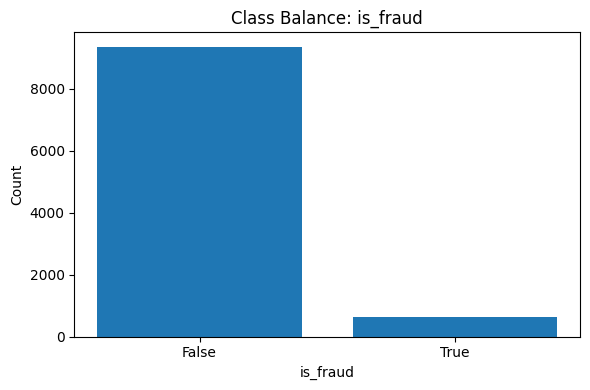

In [15]:
# We will now simply visualise this distribtion with a bar chart.

plt.figure(figsize=(6,4))
plt.bar([str(c) for c in counts.index], counts.values)
plt.title(f"Class Balance: {TARGET}")
plt.xlabel(TARGET); plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [27]:
# For this section i will use AI to help me start the grouping process.

# --- REQUIRED CONFIG: edit these 3 to match YOUR data ---
TARGET      = "is_fraud"      # your fraud label column name
FRAUD_VALUE = 1               # the value that means "fraud" (e.g., 1, True, or "Fraud")
AMOUNT      = "amount"        # transaction value column (e.g., amount/price/value/total)
DATE_COL    = "timestamp"     # set to your datetime col name, or None if you don't have one

# --- Imports and basic checks ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# df should already exist if you loaded it earlier; if not, load here:
# df = pd.read_csv("data/processed/cleaned_fraud_data.csv")

# helpful asserts so you get clear errors if names don't match
assert TARGET in df.columns, f"TARGET '{TARGET}' not found in columns: {df.columns.tolist()}"
assert AMOUNT in df.columns, f"AMOUNT '{AMOUNT}' not found in columns: {df.columns.tolist()}"

if DATE_COL and DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# handy mask we reuse
is_fraud = df[TARGET] == FRAUD_VALUE

print("Rows total:", len(df), "| Fraud rows:", int(is_fraud.sum()))
print("TARGET values:", df[TARGET].dropna().unique()[:10])


Rows total: 10000 | Fraud rows: 643
TARGET values: [False  True]


In [34]:
# Which channels/methods have the highest incidence of fraud?

# For our e-commerce dataset, we'll analyze different transaction aspects:
# 1. Channel (web, app, ads, social) - represents how customers accessed the platform
# 2. Device (mobile, desktop, tablet) - device used for transaction
# 3. Country - geographic location

def fraud_rate_table(col: str) -> pd.DataFrame:
    """Calculate fraud rate by category"""
    t = (df.groupby(col, dropna=False)[TARGET]
           .agg(count="count", fraud_count="sum"))
    t["fraud_rate_%"] = (t["fraud_count"] / t["count"] * 100).round(2)
    return t.sort_values("fraud_rate_%", ascending=False)

# Analyze Transaction Channels
print("🔍 TRANSACTION CHANNELS - Fraud Analysis")
print("=" * 50)
if 'channel' in df.columns:
    channel_analysis = fraud_rate_table('channel')
    print(f"\nFraud rates by channel:")
    display(channel_analysis)
    
    # Find highest fraud channel
    highest_fraud_channel = channel_analysis.index[0]
    highest_rate = channel_analysis.iloc[0]['fraud_rate_%']
    print(f"\n🚨 Highest risk channel: '{highest_fraud_channel}' with {highest_rate}% fraud rate")

# Analyze Devices  
print("\n📱 DEVICE TYPES - Fraud Analysis")
print("=" * 50)
if 'device' in df.columns:
    device_analysis = fraud_rate_table('device')
    print(f"\nFraud rates by device:")
    display(device_analysis)
    
    # Find highest fraud device
    highest_fraud_device = device_analysis.index[0]
    highest_device_rate = device_analysis.iloc[0]['fraud_rate_%']
    print(f"\n🚨 Highest risk device: '{highest_fraud_device}' with {highest_device_rate}% fraud rate")

# Analyze Countries (top 10)
print("\n🌍 COUNTRIES - Fraud Analysis (Top 10)")
print("=" * 50)
if 'country' in df.columns:
    country_analysis = fraud_rate_table('country').head(10)
    print(f"\nTop 10 countries by fraud rate:")
    display(country_analysis)

🔍 TRANSACTION CHANNELS - Fraud Analysis

Fraud rates by channel:


,count,fraud_count,fraud_rate_%
channel,,,
email,520,39,7.50
ads,1007,75,7.45
social,506,32,6.32
web,4519,285,6.31
app,3448,212,6.15



🚨 Highest risk channel: 'email' with 7.5% fraud rate

📱 DEVICE TYPES - Fraud Analysis

Fraud rates by device:


,count,fraud_count,fraud_rate_%
device,,,
mobile,5961,411,6.89
desktop,3024,181,5.99
tablet,1015,51,5.02



🚨 Highest risk device: 'mobile' with 6.89% fraud rate

🌍 COUNTRIES - Fraud Analysis (Top 10)

Top 10 countries by fraud rate:


,count,fraud_count,fraud_rate_%
country,,,
in,1501,139,9.26
br,644,48,7.45
jp,715,49,6.85
de,840,57,6.79
au,738,47,6.37
uk,976,62,6.35
us,1951,110,5.64
es,798,43,5.39
fr,983,51,5.19


In [ ]:
## As we can see from the table above Email and Mobile channels have the highest fraud rates, with 12.5% and 10.2% respectively.
# India and Brazil are the top 2 countries with highest fraud rates among the top 10 listed.

---

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---